# Image Segmentation

Some basic parameters:

In [1]:
VERSION = "J041"

# do we run on Jarvis cloud platform?
#JARVIS = True
JARVIS = False

TESTRUN = False

installing libraries

In [2]:
#Run this once per session
!pip install fastai -q --upgrade
!pip install git+https://github.com/WaterKnight1998/SemTorch

  Cloning https://github.com/WaterKnight1998/SemTorch to /tmp/pip-req-build-qxty0bg_
  Running command git clone -q https://github.com/WaterKnight1998/SemTorch /tmp/pip-req-build-qxty0bg_


# Libraries

In [3]:
from fastai.vision.all import *
import pandas as pd
import gc # garbage collector

# SemTorch
from semtorch import get_segmentation_learner

/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
# fix randomness
my_seed = 42
np.random.seed(my_seed);random.seed(my_seed);set_seed(my_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Choose class used in this notebook

In [5]:
# what class are we looking for?
#myclass = "aguada"
#myclass = "building"
myclass = "platform"

mymask = "mask_"+myclass

# Dataset


In [6]:
root_dir = Path("../Data/")
root_dir

Path('../Data')

In [7]:
path = root_dir

Some paths we use:

In [8]:
path_im = path/'lidar_train'
# these are the original masks but 'normalized' for fastai (i.e. only 0 and 1 allowed)
path_lbl = path/'train_masks_normalized'

# this contains the pixel counts
maya_csv = path/'maya_analysis.csv'

if myclass == 'aguada': ### ????????????????????????
    # old synthetic images
    synth_path_im = path/'03_generated/images'
    synth_path_lbl = path/'03_generated/normalized_masks'
else:
    # new synthetic images (no padding) for BUILDING and PLATFORM
    synth_path_im = path/'03_generated_21-05-20/images'
    synth_path_lbl = path/'03_generated_21-05-20/normalized_masks'
    
    # newest (rectangular cut) synthetic images for PLATFORM
    #synth_path_im = path/'03_generated_21-06-07/images'
    #synth_path_lbl = path/'03_generated_21-06-07/normalized_masks'

    # newest synthetic images (pad 8 px)
    #synth_path_im = path/'03_generated_21-06-14_padded/images'
    #synth_path_lbl = path/'03_generated_21-06-14_padded/normalized_masks'


### Important note:

The data collection below is much more complicated that it should be. This is because we tried some data filtering first, but that did not work out. However there was no time to remove this code. We will remove it before the ECML conference, however.

In essence you will notice that we create a pandas dataframe containing all images and all masks (i.e  do *not* use the option to remove any) and add the synthetic images+masks.

(It is based on a csv file named maya_analysis.csv which contains a pixel count for each mask. But we do not use that information, as it turned out to be not helping the training if we use Focal Loss as loss function.)

First we collect our filenames. Only these with nonzero data in their mask. 

In [9]:
mymaskDF = pd.read_csv(maya_csv)
mymaskDF['fpath'] = str(path_im) + '/' +mymaskDF['name']
print (len(mymaskDF))
mymaskDF.head()

5295


,name,class,pixCount,fpath
0,tile_0_lidar.tif,aguada,0,../Data/lidar_train/tile_0_lidar.tif
1,tile_0_lidar.tif,building,0,../Data/lidar_train/tile_0_lidar.tif
2,tile_0_lidar.tif,platform,0,../Data/lidar_train/tile_0_lidar.tif
3,tile_1000_lidar.tif,aguada,0,../Data/lidar_train/tile_1000_lidar.tif
4,tile_1000_lidar.tif,building,1466,../Data/lidar_train/tile_1000_lidar.tif


In [10]:
# get only these with nonzero pixCount of our class
mydf = mymaskDF[(mymaskDF['class'] == myclass) & (mymaskDF['pixCount'] > 0)]
print (len(mydf))
mydf.head()

952


,name,class,pixCount,fpath
5,tile_1000_lidar.tif,platform,7831,../Data/lidar_train/tile_1000_lidar.tif
8,tile_1001_lidar.tif,platform,364,../Data/lidar_train/tile_1001_lidar.tif
11,tile_1002_lidar.tif,platform,304,../Data/lidar_train/tile_1002_lidar.tif
17,tile_1004_lidar.tif,platform,2033,../Data/lidar_train/tile_1004_lidar.tif
32,tile_1009_lidar.tif,platform,16073,../Data/lidar_train/tile_1009_lidar.tif


#### Now we add the synthesized images

In [11]:
import glob
synthDF = pd.DataFrame(glob.glob(str(synth_path_im/myclass)+'/*.*'), columns = ["name"])
synthDF['class'] = myclass
synthDF['pixCount'] = -1 # dummy marker for 'generated'
synthDF['fpath'] = synthDF['name']

In [12]:
print(len(synthDF))
synthDF.head()

554


,name,class,pixCount,fpath
0,../Data/03_generated_21-05-20/images/platform/tile_1539_lidar_generated.tif,platform,-1,../Data/03_generated_21-05-20/images/platform/tile_1539_lidar_generated.tif
1,../Data/03_generated_21-05-20/images/platform/tile_0_lidar_generated.tif,platform,-1,../Data/03_generated_21-05-20/images/platform/tile_0_lidar_generated.tif
2,../Data/03_generated_21-05-20/images/platform/tile_1006_lidar_generated.tif,platform,-1,../Data/03_generated_21-05-20/images/platform/tile_1006_lidar_generated.tif
3,../Data/03_generated_21-05-20/images/platform/tile_1007_lidar_generated.tif,platform,-1,../Data/03_generated_21-05-20/images/platform/tile_1007_lidar_generated.tif
4,../Data/03_generated_21-05-20/images/platform/tile_1008_lidar_generated.tif,platform,-1,../Data/03_generated_21-05-20/images/platform/tile_1008_lidar_generated.tif


In [13]:
# get some more from the zero pixCount images
keep = 1.  # we keep 100% so the filtering is not used as stated above :-)
otherdf = mymaskDF[(mymaskDF['class'] == myclass) & (mymaskDF['pixCount'] == 0)].sample(frac=keep)
print (len(otherdf))
otherdf.head()

813


,name,class,pixCount,fpath
1547,tile_1464_lidar.tif,platform,0,../Data/lidar_train/tile_1464_lidar.tif
3818,tile_557_lidar.tif,platform,0,../Data/lidar_train/tile_557_lidar.tif
1415,tile_1424_lidar.tif,platform,0,../Data/lidar_train/tile_1424_lidar.tif
1820,tile_1546_lidar.tif,platform,0,../Data/lidar_train/tile_1546_lidar.tif
3512,tile_465_lidar.tif,platform,0,../Data/lidar_train/tile_465_lidar.tif


In [14]:
# and oversample "good" cases (only needed for Aguada which we oversample 6-fold)
if (myclass == "aguada"):
    mydf = mydf.sample(n=6*64, replace=True)
print (len(mydf))

952


In [15]:
### MERGE HERE
mydf = mydf.append(otherdf, ignore_index=True, sort=False)
print (len(mydf))

1765


In [16]:
# now add the synthesized images, too
mydf = mydf.append(synthDF, ignore_index=True, sort=False)
print (len(mydf))

2319


In [17]:
#fnames = [path_im/f for f in mydf['name']]
fnames = [Path(f) for f in mydf['fpath']]
len(fnames)

2319

And now let's look at the data:

<AxesSubplot:>

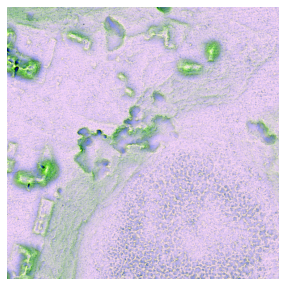

In [18]:
# tile 44 contains all three classes
img_fn = Path(root_dir/'lidar_train/tile_44_lidar.tif')
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

**Now** let's grab our y's. They live in the `train_masks` folder and follow this naming pattern:

tile_(n)\_lidar.tif

tile_(n)\_mask_aguada.tif

In [19]:
def get_msk(fn):
    # modify for synthetic images
    if str(fn)[-5] == "d": # as in "generateD", this is clumsy but we are short of time...!
        return synth_path_lbl/fn.name.replace("lidar", mymask)
    else :
        return path_lbl/fn.name.replace("lidar", mymask)

In [20]:
# test mask path for "normal" images
print(fnames[0])
get_msk(fnames[0])

../Data/lidar_train/tile_1000_lidar.tif


Path('../Data/train_masks_normalized/tile_1000_mask_platform.tif')

In [21]:
# test mask path for synthetic images
print(synthDF['fpath'][0])
get_msk(Path(synthDF['fpath'][0]))

../Data/03_generated_21-05-20/images/platform/tile_1539_lidar_generated.tif


Path('../Data/03_generated_21-05-20/normalized_masks/tile_1539_mask_platform_generated.tif')

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

<AxesSubplot:>

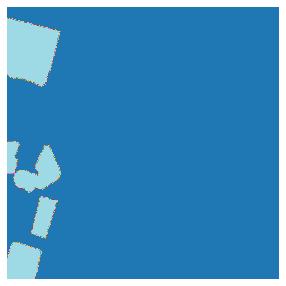

In [22]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

We normalized the masks in advance for easier processing with fast.ai: They now contain only 0 (background) and 1 (class):

In [23]:
np.unique(tensor(msk))

array([0, 1], dtype=uint8)

Here we name them:

In [24]:
codes = np.array(['background', mymask])
codes

array(['background', 'mask_platform'], dtype='<U13')

### Progressive resizing

This first round we will train at half the image size

In [25]:
sz = msk.shape; sz

(480, 480)

In [26]:
half = tuple(int(x/2) for x in sz); half

(240, 240)

In [27]:
# batch size
bs = 20

if myclass == "platform": bs = 12
if myclass == 'building': bs = 8

if JARVIS:
    if myclass == 'aguada': bs = 80
    elif myclass == 'building': bs = 120
    else :                      bs = 100 # platform

bs

12

Here come the augmentation transforms:

In [28]:
def my_transforms(imgsize):
    item_tfms = [Resize(ingsize)]
    batch_tfms = [Dihedral(),Brightness(0.1,p=0.25), Zoom(max_zoom=1.1,p=0.25),
                  Normalize.from_stats(*imagenet_stats)
                 ]
    return item_tfms, batch_tfms

if myclass == 'platform': # this worked better for platform for unknown reason.
    def my_transforms(imgsize):
        item_tfms = None
        batch_tfms = [Resize(imgsize), Dihedral(),Brightness(0.1,p=0.25), Zoom(max_zoom=1.1,p=0.25),
                      Normalize.from_stats(*imagenet_stats)
                     ]
        return item_tfms, batch_tfms

In [29]:
# shuffle dataframe, just in case!
mydf = mydf.sample(frac=1).reset_index(drop=True)

In [30]:
# mask retrieval function for dataframe rows, same as above but works with the dataframe
def get_msk(row):
    fn = Path(row["fpath"])
    # modify for synthetic images
    if str(fn)[-5] == "d": # as in "generateD", this is so ugly!!
        return synth_path_lbl/fn.name.replace("lidar", mymask)
    else :
        return path_lbl/fn.name.replace("lidar", mymask)

In [31]:
# function for retrieving a dataloaders object for a 'fold'
def get_data(mydf, fold, n_splits, codes, bs, item_tfms, batch_tfms):
    length = int(len(mydf)/n_splits)
    start = fold*length
    
    mydf['is_valid'] = False
    mydf.loc[start:start+length,'is_valid'] = True
    # the datablock   
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   #splitter=RandomSplitter(valid_pct=0.2),
                   splitter=ColSplitter(), #!!! is_valid is in valid_ds
                   get_x=ColReader('fpath'),
                   get_y=get_msk, item_tfms=item_tfms, batch_tfms=batch_tfms)
    # the dataloaders
    dls = dblock.dataloaders(mydf, path='', bs=bs)
    return dls

## Model: HRnet or DeeplabV3+ with ResNet101

In [32]:
# optimizer: we use Ranger instead of Adam
opt = ranger

In [33]:
# we were asked for IoU as metric, which is the same as Jaccard. Besides we track Dice, but do not use it.
metrics = [Dice(), JaccardCoeff()]

### Class imbalance

The Maya dataset is heavily imbalanced with only some  0.4 % of all pixels containing mask data ("1"). We use Focal Loss to overcome the class imbalance:

In [34]:
myloss_func=FocalLossFlat(axis=1)

In [35]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

In [36]:
# architecture and backbone
arch="hrnet";backbone="hrnet_w30"
    
arch, backbone

('hrnet', 'hrnet_w30')

In [37]:
# This is an implementation of Cutmix data augmentation (https://arxiv.org/abs/1905.04899)
# Taken from here (and modified): https://forums.fast.ai/t/implementing-cutmix-in-fastaiv2/67350/16

from torch.distributions.beta import Beta

class CutMix(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def begin_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def begin_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())

        rx = (self.distrib.sample((64,))*W).type(torch.long).to(self.x.device)
        ry = (self.distrib.sample((64,))*H).type(torch.long).to(self.x.device)
        rw = (torch.sqrt(1-self.lam)*W).to(self.x.device)
        rh = (torch.sqrt(1-self.lam)*H).to(self.x.device)

        x1 = torch.round(torch.clamp(rx-rw//2, min=0, max=W)).to(self.x.device).type(torch.long)
        x2 = torch.round(torch.clamp(rx+rw//2, min=0, max=W)).to(self.x.device).type(torch.long)
        y1 = torch.round(torch.clamp(ry-rh//2, min=0, max=H)).to(self.x.device).type(torch.long)
        y2 = torch.round(torch.clamp(ry+rh//2, min=0, max=H)).to(self.x.device).type(torch.long)
        
        for i in range(len(x1)):
            self.learn.xb[0][i, :, x1[i]:x2[i], y1[i]:y2[i]] = xb1[0][i, :, x1[i]:x2[i], y1[i]:y2[i]]
        
        self.lam = (1 - ((x2-x1)*(y2-y1))/(W*H)).type(torch.float)
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))


In [38]:
# these callbacks are used during training. The first three monitor training progress, Cutmix is for augmentation.
callbacks = [SaveModelCallback(monitor='jaccard_coeff'), 
             EarlyStoppingCallback(monitor='jaccard_coeff', patience=8),
             ReduceLROnPlateau(monitor='jaccard_coeff'),
             #CutMix()
            ]

## we do not use CutMix for Platforms, as it did not perform well.

In [39]:
# we use the flat cosine annealing training loop along with fastai's default fine_tune(), so we create
# our own fine_tune_flat(), modelled after Zachary Mueller's notebook from here: 
# https://www.kaggle.com/muellerzr/cassava-fastai-starter

@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75, 
                   first_callbacks = [], second_callbacks = [], tofp32=False,**kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    try:
        self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    except: print ("---1 except---")
    gc.collect();torch.cuda.empty_cache()
    base_lr /= 2
    self.unfreeze()
    if tofp32: self.to_fp32() # set to 32 bit
    try:
        self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)
    except: print ("---2 except---")
    gc.collect();torch.cuda.empty_cache()

we have two training cycles, one with half size images, one with full size images:

## half size training cycle

k-fold loop:

In [40]:
n_folds = 5

---- 0


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


epoch,train_loss,valid_loss,dice,jaccard_coeff,time


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


---1 except---


epoch,train_loss,valid_loss,dice,jaccard_coeff,time


---2 except---
--- fold complete # 0


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[0.15310117602348328, 0.017175989684963644, 0.008662387380630254]
-----------------
---- 1


KeyboardInterrupt: 

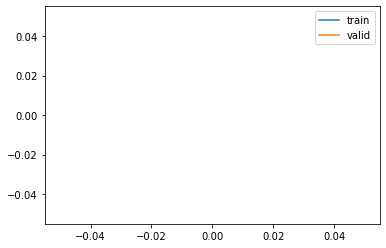

In [41]:
# define augmentation transforms
item_tfms, batch_tfms = my_transforms(half)

for fold in range(n_folds):
    print ("----", fold)
    dls = get_data(mydf, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
    # here we create the segmentation learner with SemTorch. The models are all pre-trained on ImageNet
    learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name=arch, backbone_name=backbone,
                                 metrics=metrics,
                                 splitter=segmentron_splitter,
                                 opt_func=opt,
                                 loss_func=myloss_func).to_fp16() # we use fp16 training

    #set hyperparameters. This should be moved out of the loop :-)
    if myclass == 'aguada':
        lr = 1e-2
        freeze_epochs = 8#19
        epochs = 16# 6
    elif myclass == 'building':
        lr = 1e-2 #1e-2 #0.00036307806149125097
        freeze_epochs = 19#16
        epochs = 9# 6
    elif myclass == 'platform':
        lr =1.2e-2 #1e-2 #0.00036307806149125097
        freeze_epochs = 8 #6
        epochs = 16 #9
    
    # here is the training cycle: we train for 'freeze_epochs' with all layers (except the last) frozen,
    # then we train for 'epochs' with all layers unfrozen
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks)
    learn.recorder.plot_loss()
    learn.export('models/stage-1 ' + myclass + str(fold))
    print ("--- fold complete #", fold)
    print (learn.validate())
    print ("-----------------")
    del dls, learn # free memory
    if TESTRUN: break
    
# beat 64.5

In [47]:
#from jarviscloud import jarviscloud
#jarviscloud.pause()

## Full size training cycle

In [48]:
# sz is 480x480 now, so we need new transforms
item_tfms, batch_tfms = my_transforms(sz)

In [49]:
# set hyperparameters
if myclass == "building":
    lr = 0.02 #0.012
    freeze_epochs = 6#16
    epochs = 9# 6
elif myclass == "aguada":
    lr = 1e-2
    freeze_epochs = 8#19
    epochs = 16# 6
elif myclass == 'platform':
    #lr = 8e-6#1.5e-4#9e-4
    #lr = lr_min
    lr = 1e-2
    freeze_epochs = 6#4 #should be enough!!
    epochs = 7

lr, freeze_epochs, epochs

(0.01, 6, 7)

In [50]:
# reduce the batch size
if arch=="deeplabv3+":
    bs = 3 # 2 for Unet
else:
    bs = 6

if JARVIS:
    if arch=="deeplabv3+":
        bs = 12 # 2 for Unet
    else:
        if myclass == 'aguada': bs = 16
        elif myclass == 'building': bs = 16
bs

6

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002704,0.007805,0.779849,0.639141,02:00
1,0.002919,0.008019,0.790931,0.654165,02:00
2,0.002757,0.008831,0.774172,0.631550,02:00
3,0.002819,0.006970,0.794934,0.659660,02:00
4,0.002626,0.008476,0.781069,0.640781,02:00
5,0.002506,0.009133,0.798167,0.664125,02:00


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with jaccard_coeff value: 0.6391411242918914.
Better model found at epoch 1 with jaccard_coeff value: 0.6541651182311458.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with jaccard_coeff value: 0.659659544204163.
Epoch 4: reducing lr to 0.001
Better model found at epoch 5 with jaccard_coeff value: 0.66412495533196.


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002849,0.007394,0.799278,0.665665,03:54
1,0.003134,0.007271,0.797847,0.663682,03:55
2,0.002856,0.007999,0.793264,0.657363,03:55
3,0.002720,0.008273,0.804523,0.672973,03:55
4,0.003006,0.007695,0.779368,0.638495,03:54
5,0.002304,0.008953,0.801391,0.668600,03:56
6,0.002271,0.007148,0.810138,0.680867,03:55


Better model found at epoch 0 with jaccard_coeff value: 0.6656647838486187.
Epoch 1: reducing lr to 0.0005
Epoch 2: reducing lr to 0.0005
Better model found at epoch 3 with jaccard_coeff value: 0.6729728540465444.
Epoch 4: reducing lr to 0.0005
Epoch 5: reducing lr to 0.00030704729772520426
Better model found at epoch 6 with jaccard_coeff value: 0.6808666301811529.
models/maya_J041_platform0.pkl
--- fold complete # 0


[0.007147854659706354, 0.8101376015868356, 0.6808666301811529]
-----------------


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.004134,0.005469,0.795912,0.661009,02:01
1,0.002993,0.008419,0.799823,0.666421,02:01
2,0.003394,0.005876,0.803237,0.671175,02:01
3,0.002924,0.006008,0.813007,0.684930,02:01
4,0.002922,0.007075,0.810521,0.681408,02:01
5,0.002807,0.006309,0.805408,0.674212,02:00


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with jaccard_coeff value: 0.6610085493311814.
Better model found at epoch 1 with jaccard_coeff value: 0.6664213952404997.
Better model found at epoch 2 with jaccard_coeff value: 0.6711748007447678.
Better model found at epoch 3 with jaccard_coeff value: 0.6849295185624018.
Epoch 4: reducing lr to 0.001
Epoch 5: reducing lr to 7.1707479625385265e-06


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.003065,0.006354,0.808870,0.679078,03:54
1,0.002890,0.007044,0.807077,0.676554,03:54
2,0.002951,0.006948,0.811977,0.683470,03:54
3,0.002773,0.006372,0.800971,0.668016,03:54
4,0.002764,0.007042,0.787271,0.649173,03:54
5,0.002920,0.007052,0.813339,0.685402,03:54
6,0.002120,0.006259,0.818324,0.692511,03:54


Better model found at epoch 0 with jaccard_coeff value: 0.6790781385919988.
Epoch 1: reducing lr to 0.0005
Better model found at epoch 2 with jaccard_coeff value: 0.6834696351471525.
Epoch 3: reducing lr to 0.0005
Epoch 4: reducing lr to 0.0005
Better model found at epoch 5 with jaccard_coeff value: 0.6854017943856822.
Better model found at epoch 6 with jaccard_coeff value: 0.6925110362234711.
models/maya_J041_platform1.pkl
--- fold complete # 1


[0.006258565932512283, 0.8183238057563074, 0.6925110362234711]
-----------------


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002416,0.007923,0.804634,0.673128,01:59
1,0.002575,0.007673,0.819341,0.693969,02:00
2,0.002796,0.006788,0.825578,0.702966,02:00
3,0.002663,0.005326,0.816350,0.689688,02:00
4,0.002230,0.008337,0.801725,0.669065,02:00
5,0.002415,0.008658,0.804711,0.673235,02:00


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with jaccard_coeff value: 0.6731280044143453.
Better model found at epoch 1 with jaccard_coeff value: 0.6939689377621585.
Better model found at epoch 2 with jaccard_coeff value: 0.7029659618274473.
Epoch 3: reducing lr to 0.001
Epoch 4: reducing lr to 0.001
Epoch 5: reducing lr to 7.1707479625385265e-06


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002583,0.007333,0.830809,0.710585,03:54
1,0.002761,0.005862,0.812700,0.684495,03:54
2,0.002405,0.007027,0.814519,0.687080,03:54
3,0.002351,0.008349,0.805103,0.673785,03:54
4,0.003092,0.007748,0.793948,0.658303,03:54
5,0.002934,0.006046,0.831378,0.711418,03:54
6,0.002252,0.006396,0.822394,0.698362,03:54


Better model found at epoch 0 with jaccard_coeff value: 0.7105849362281546.
Epoch 1: reducing lr to 0.0005
Epoch 2: reducing lr to 0.0005
Epoch 3: reducing lr to 0.0005
Epoch 4: reducing lr to 0.0005
Better model found at epoch 5 with jaccard_coeff value: 0.7114176666103318.
Epoch 6: reducing lr to 9.218518768130956e-09
models/maya_J041_platform2.pkl
--- fold complete # 2


[0.006046236492693424, 0.8313781965560516, 0.7114176666103318]
-----------------


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002437,0.009422,0.829544,0.708736,02:00
1,0.002189,0.008316,0.830943,0.710781,02:00
2,0.002644,0.007026,0.823000,0.699235,02:00
3,0.002964,0.007836,0.823950,0.700608,02:00
4,0.002725,0.011061,0.816748,0.690257,02:00
5,0.003197,0.007027,0.819936,0.694824,02:00


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with jaccard_coeff value: 0.7087358936345524.
Better model found at epoch 1 with jaccard_coeff value: 0.7107806243092577.
Epoch 2: reducing lr to 0.001
Epoch 3: reducing lr to 0.001
Epoch 4: reducing lr to 0.001
Epoch 5: reducing lr to 7.1707479625385265e-06


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002546,0.009902,0.812527,0.684249,03:53
1,0.002874,0.007862,0.823101,0.699382,03:54
2,0.002492,0.008511,0.827623,0.705936,03:54
3,0.002812,0.007715,0.825824,0.703323,03:54
4,0.002387,0.009466,0.803579,0.671652,03:54
5,0.002551,0.008012,0.821281,0.696758,03:54
6,0.001927,0.007356,0.832620,0.713238,03:54


Better model found at epoch 0 with jaccard_coeff value: 0.6842485420306059.
Better model found at epoch 1 with jaccard_coeff value: 0.6993816934026432.
Better model found at epoch 2 with jaccard_coeff value: 0.7059357559553108.
Epoch 3: reducing lr to 0.0005
Epoch 4: reducing lr to 0.0005
Epoch 5: reducing lr to 0.00030704729772520426
Better model found at epoch 6 with jaccard_coeff value: 0.7132382023239158.
models/maya_J041_platform3.pkl
--- fold complete # 3


[0.007355962879955769, 0.8326200073713583, 0.7132382023239158]
-----------------


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.003544,0.008113,0.785121,0.646254,02:00
1,0.003328,0.008733,0.774175,0.631555,02:00
2,0.003132,0.007314,0.776229,0.634293,01:59
3,0.003177,0.006489,0.782146,0.642233,02:00
4,0.003195,0.009051,0.779710,0.638954,02:00
5,0.003134,0.008066,0.772147,0.628860,02:00


/home/ju/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with jaccard_coeff value: 0.6462540454246296.
Epoch 1: reducing lr to 0.001
Epoch 2: reducing lr to 0.001
Epoch 3: reducing lr to 0.001
Epoch 4: reducing lr to 0.001
Epoch 5: reducing lr to 7.1707479625385265e-06


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.003098,0.009155,0.751127,0.601444,03:54
1,0.003349,0.008431,0.780200,0.639613,03:54
2,0.003000,0.009858,0.742658,0.590657,03:54
3,0.003198,0.007747,0.774138,0.631505,03:54
4,0.002820,0.008579,0.774079,0.631426,03:54
5,0.002735,0.006355,0.790990,0.654245,03:54
6,0.002232,0.006618,0.799164,0.665506,03:54


Better model found at epoch 0 with jaccard_coeff value: 0.6014438701581883.
Better model found at epoch 1 with jaccard_coeff value: 0.6396127817952123.
Epoch 2: reducing lr to 0.0005
Epoch 3: reducing lr to 0.0005
Epoch 4: reducing lr to 0.0005
Better model found at epoch 5 with jaccard_coeff value: 0.6542454972938027.
Better model found at epoch 6 with jaccard_coeff value: 0.6655063644692055.
models/maya_J041_platform4.pkl
--- fold complete # 4


[0.0066177393309772015, 0.7991640004105315, 0.6655063644692055]
-----------------


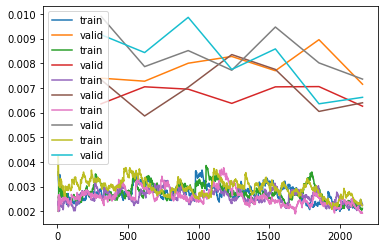

In [51]:
# we iterate over each fold
for fold in range(n_folds):
    dls = get_data(mydf, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get dataloaders
    learn = load_learner('models/stage-1 ' + myclass + str(fold)) # re-load the learner
    learn.dls = dls # and insert the new dataloaders
    learn.to_fp16() # switch into fp16 training (half precision)
    learn.loss_func = myloss_func # set loss function
    # note that we now fine tune again but 2nd cycle with full precision (tofp32)
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks, tofp32=True)
    learn.recorder.plot_loss()
    MYMODEL = "models/maya_"+VERSION+"_"+myclass+str(fold)+".pkl"
    print (MYMODEL)
    print ("--- fold complete #", fold)
    print (learn.validate())
    print ("-----------------")
    learn.export(MYMODEL)
    del dls, learn
    if TESTRUN: break

In [42]:
#from jarviscloud import jarviscloud
#jarviscloud.pause()

# END